In [1]:
import tensorflow as tf
import qkera_experiments.dataset as dataset
from tensorflow import keras
from keras import layers
from qkeras import *

# load the dataset

In [2]:
x_train, y_train, x_test, y_test = dataset.load_cifar10()

(50000, 1)


# define learning rate scheduler

In [3]:
class ResNetPaperLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr = 0.1, learning_rate_decay=10, steps=[32000, 48000]):
        super(ResNetPaperLR, self).__init__()
        self.initial_lr = initial_lr
        self.learning_rate_decay = learning_rate_decay
        self.steps = steps
        self.current_lr = 0
    def __call__(self, step):        
        step12 = tf.where(step < self.steps[1], self.initial_lr/self.learning_rate_decay, self.initial_lr/(self.learning_rate_decay**2))    
        step01 = tf.where(step < self.steps[0], self.initial_lr, step12)
        return step01
                         

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "learning_rate_decay": self.learning_rate_decay,
            "steps": self.steps
        }

# load the model

In [4]:
from qkeras.utils import load_qmodel


qmodel = load_qmodel("qmodels/resnet32/model.h5", custom_objects={"ResNetPaperLR":ResNetPaperLR})
qmodel.evaluate(x_test, y_test)

x_in = qmodel.layers[0].input
x_out = qmodel.layers[-2].output

base_model = keras.Model(inputs=[x_in], outputs=[x_out])
base_model.summary()

del qmodel

c:\Users\georg\Desktop\mestrado_luiz\deep_nibble_dnn\.venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 23s 48ms/step - loss: 1.3030 - accuracy: 0.6156
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 q_activation (QActivation)     (None, 32, 32, 3)    0           ['input[0][0]']                  
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 34, 34, 3)    0           ['q_activation[0][0]']           
                                                                                                  
 qconv1 (QConv2D)               (None, 32, 32, 16)   432         ['conv1_pad[0][0]']              
   

# including base model as a preprocessing component of the Deep Nibble MLP training

In [5]:
# preprocess the dataset
x_train_2 = base_model.predict(x_train)
print(x_train_2.shape)
# preprocess the dataset
x_test_2 = base_model.predict(x_test)
print(x_test_2.shape)

1563/1563 [==============================] - 76s 45ms/step
(50000, 64)
313/313 [==============================] - 14s 45ms/step
(10000, 64)


# training Deep Nibble

In [6]:
import numpy as np
import tensorflow as tf
from mlp_from_scratch.NeuralNetwork import QNeuralNetworkWithScale


# Define neural network inputnoutput
input_size = x_train_2.shape[1]
output_size = y_train.shape[1]

print(x_train_2.shape, x_test_2.shape, y_train.shape, y_test.shape)



(50000, 64) (10000, 64) (50000, 10) (10000, 10)


In [8]:
deep_nibble_history = []

for i in range(10):

    # Create and train the neural network
    neural_network_with_scale = QNeuralNetworkWithScale(input_size, output_size)

    # train the nn
    neural_network_with_scale.train(x_train_2, y_train, learning_rate=0.000100, num_epochs=5, batch_size=256, x_val=x_test_2, y_val=y_test)
    neural_network_with_scale.train(x_train_2, y_train, learning_rate=0.000010, num_epochs=15, batch_size=256, x_val=x_test_2, y_val=y_test)

    neural_network_with_scale.save_weights(f"dn_models/deep_nibble_model_{i}")

    np.save(f"dn_models/deep_nibble_model_{i}/loss_hist", np.array(neural_network_with_scale.loss_hist))
    np.save(f"dn_models/deep_nibble_model_{i}/acc_hist", np.array(neural_network_with_scale.acc_hist))

    deep_nibble_history.append((neural_network_with_scale.loss_hist , neural_network_with_scale.acc_hist))
    


Epoch 1/5, Loss: 0.006597291212528944 Accuracy: 23.459999084472656%
Epoch 2/5, Loss: 0.00743182422593236 Accuracy: 24.06999969482422%
Epoch 3/5, Loss: 0.011624624952673912 Accuracy: 38.08000183105469%
Epoch 4/5, Loss: 0.008379846811294556 Accuracy: 58.25%
Epoch 5/5, Loss: 0.013117942027747631 Accuracy: 46.41999816894531%
Epoch 1/15, Loss: 0.010023629292845726 Accuracy: 44.72999954223633%
Epoch 2/15, Loss: 0.01078293938189745 Accuracy: 49.73999786376953%
Epoch 3/15, Loss: 0.011041434481739998 Accuracy: 48.78999710083008%
Epoch 4/15, Loss: 0.010281402617692947 Accuracy: 47.22999954223633%
Epoch 5/15, Loss: 0.009676101617515087 Accuracy: 45.599998474121094%
Epoch 6/15, Loss: 0.010615776292979717 Accuracy: 45.2400016784668%
Epoch 7/15, Loss: 0.010207189247012138 Accuracy: 45.13999938964844%
Epoch 8/15, Loss: 0.011528437957167625 Accuracy: 43.29999923706055%
Epoch 9/15, Loss: 0.009796740487217903 Accuracy: 44.47999954223633%
Epoch 10/15, Loss: 0.009820359759032726 Accuracy: 45.1100006103515

# training fp32

In [31]:
def scheduler(epoch):
  if epoch < 1:
    return 0.01
  elif epoch < 5:
    return 0.01
  else:
    return 0.001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


fp_history = []

for i in range(10):
  x = x_in = keras.layers.Input((64))
  x = keras.layers.Dense(units=256, activation="relu")(x)
  x = keras.layers.Dense(units=256, activation="relu")(x)
  x = keras.layers.Dense(units=10)(x)
  fp_model = keras.Model(inputs=x_in, outputs=x)
  fp_model.compile(keras.optimizers.SGD(learning_rate=0.001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
  fp_hist = fp_model.fit(x_train_2, y_train, batch_size=256, epochs=20, validation_data=(x_test_2, y_test), callbacks=[callback])

  fp_model.save(f"fp_models/model_{i}.h5")
  np.save(f"fp_models/model_{i}_acc_hist",  np.array(fp_hist.history["val_loss"]))
  np.save(f"fp_models/model_{i}_loss_hist",  np.array(fp_hist.history["val_accuracy"]))

  fp_history.append((fp_hist.history["val_loss"], fp_hist.history["val_accuracy"]))


Epoch 1/20
196/196 [==============================] - 1s 2ms/step - loss: 1.9349 - accuracy: 0.5813 - val_loss: 1.6886 - val_accuracy: 0.5926 - lr: 0.0100
Epoch 2/20
196/196 [==============================] - 0s 2ms/step - loss: 1.2709 - accuracy: 0.7989 - val_loss: 1.2642 - val_accuracy: 0.6151 - lr: 0.0100
Epoch 3/20
196/196 [==============================] - 0s 2ms/step - loss: 0.8659 - accuracy: 0.8241 - val_loss: 1.1018 - val_accuracy: 0.6257 - lr: 0.0100
Epoch 4/20
196/196 [==============================] - 0s 2ms/step - loss: 0.6744 - accuracy: 0.8346 - val_loss: 1.0571 - val_accuracy: 0.6276 - lr: 0.0100
Epoch 5/20
196/196 [==============================] - 0s 2ms/step - loss: 0.5787 - accuracy: 0.8411 - val_loss: 1.0538 - val_accuracy: 0.6311 - lr: 0.0100
Epoch 6/20
196/196 [==============================] - 0s 2ms/step - loss: 0.5439 - accuracy: 0.8438 - val_loss: 1.0537 - val_accuracy: 0.6305 - lr: 0.0010
Epoch 7/20
196/196 [==============================] - 0s 2ms/step - lo

# training po2

In [32]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  elif epoch < 5:
    return 0.001
  else:
    return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

po2_history = []

for i in range(10):

  x = x_in = keras.layers.Input((64))
  x = QActivation(activation="quantized_relu_po2(4,1, use_stochastic_rounding=True)")(x)
  x = QDense(units=256, kernel_quantizer=quantized_po2(4,1, use_stochastic_rounding=True), bias_quantizer=(quantized_po2(4,1, use_stochastic_rounding=True)))(x)
  x = QActivation(activation="quantized_relu_po2(4,1, use_stochastic_rounding=True)")(x)
  x = QDense(units=256, kernel_quantizer=quantized_po2(4,1, use_stochastic_rounding=True), bias_quantizer=(quantized_po2(4,1, use_stochastic_rounding=True)))(x)
  x = QActivation(activation="quantized_relu_po2(4,1, use_stochastic_rounding=True)")(x)
  x = QDense(units=10, kernel_quantizer=quantized_po2(4,1, use_stochastic_rounding=True), bias_quantizer=(quantized_po2(4,1, use_stochastic_rounding=True)))(x)
  x = QActivation(activation=quantized_bits(4, 0, 1, use_stochastic_rounding=False))(x)
  po2_model = keras.Model(inputs=x_in, outputs=x)
  po2_model.compile(keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

  po2_hist = po2_model.fit(x_train_2, y_train, batch_size=256, epochs=20, validation_data=(x_test_2, y_test), callbacks=[callback])

  po2_model.save(f"po2_models/model_{i}.h5")
  np.save(f"po2_models/model_{i}_acc_hist",  np.array(po2_hist.history["val_accuracy"]))
  np.save(f"po2_models/model_{i}_loss_hist",  np.array(po2_hist.history["val_loss"]))


  po2_history.append((po2_hist.history["val_loss"], po2_hist.history["val_accuracy"]))



Epoch 1/20
196/196 [==============================] - 2s 6ms/step - loss: 2.1850 - accuracy: 0.2257 - val_loss: 2.0686 - val_accuracy: 0.3129 - lr: 0.0010
Epoch 2/20
196/196 [==============================] - 1s 5ms/step - loss: 1.9155 - accuracy: 0.4461 - val_loss: 1.9099 - val_accuracy: 0.4210 - lr: 0.0010
Epoch 3/20
196/196 [==============================] - 1s 5ms/step - loss: 1.7582 - accuracy: 0.5643 - val_loss: 1.8019 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 4/20
196/196 [==============================] - 1s 5ms/step - loss: 1.6544 - accuracy: 0.6209 - val_loss: 1.7369 - val_accuracy: 0.5112 - lr: 0.0010
Epoch 5/20
196/196 [==============================] - 1s 5ms/step - loss: 1.5963 - accuracy: 0.6460 - val_loss: 1.7000 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 6/20
196/196 [==============================] - 1s 5ms/step - loss: 1.5742 - accuracy: 0.6419 - val_loss: 1.6965 - val_accuracy: 0.5090 - lr: 1.0000e-04
Epoch 7/20
196/196 [==============================] - 1s 5ms/step 

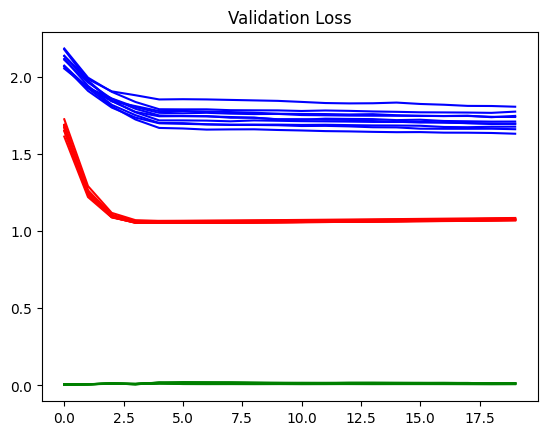

In [33]:
import matplotlib.pyplot as plt

for i in range(10):
    dn_loss = deep_nibble_history[i][0]
    
    plt.plot(fp_history[i][0], label='FP32', color="red")
    plt.plot(po2_history[i][0], label='Po2 4-bits', color="blue")
    plt.plot(dn_loss, label='Deep Nibble', color="green")    
    plt.title('Validation Loss')

# plt.legend()
plt.show()   



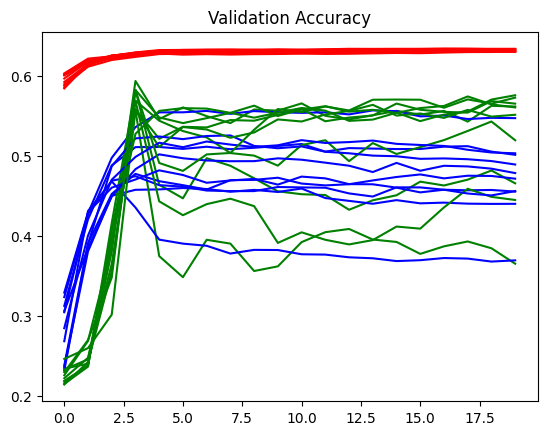

In [34]:

for i in range(10):
    dn_acc = deep_nibble_history[i][1]
        
    plt.plot(fp_history[i][1], label='FP32', color="red")
    plt.plot(po2_history[i][1], label='Po2 4-bits', color="blue")
    plt.plot(dn_acc, label='Deep Nibble', color="green")    
    plt.title('Validation Accuracy')

#plt.legend()
plt.show()   

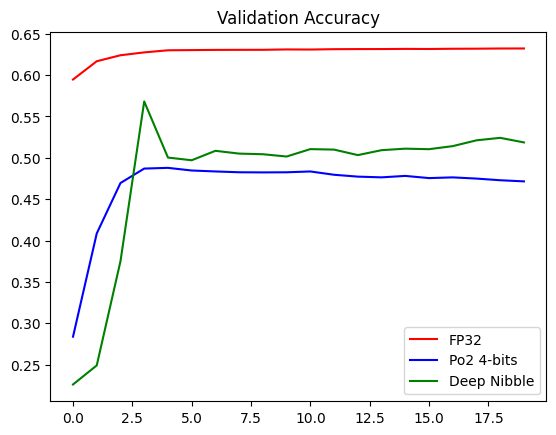

In [40]:
dn_acc = np.mean(np.array(deep_nibble_history)[:,1,:], axis=0)
fp_acc = np.mean(np.array(fp_history)[:,1,:], axis=0)
po2_acc = np.mean(np.array(po2_history)[:,1,:], axis=0)

plt.plot(fp_acc, label='FP32', color="red")
plt.plot(po2_acc, label='Po2 4-bits', color="blue")
plt.plot(dn_acc, label='Deep Nibble', color="green")    
plt.title('Validation Accuracy')

plt.legend()
plt.show()   


In [ ]:
import matplotlib.pyplot as plt



#plt.plot(history.history["loss"])
plt.plot(fp_hist.history["val_loss"], label='FP32')
plt.plot(po2_hist.history["val_loss"], label='Po2 4-bits')
plt.plot(neural_network_with_scale.loss_hist, label='Deep Nibble')
plt.legend()
plt.title('Validation Loss')
plt.show()    
#plt.plot(history.history["accuracy"])
plt.plot(fp_hist.history["val_accuracy"], label='FP32')
plt.plot(po2_hist.history["val_accuracy"],  label='Po2 4-bits')
plt.plot(neural_network_with_scale.acc_hist, label='Deep Nibble')
plt.legend()
plt.title('Validation Accuracy Cifar10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Top-1')
plt.xticks(range(0, 20, 2))

plt.show()    

In [ ]:
print(np.array(neural_network_with_scale.acc_hist))